<a href="https://colab.research.google.com/github/KeeganMcWW/ml-projects/blob/main/IASIM2016_Challenege_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and set up the Colab

In [1]:
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
from scipy.signal import savgol_filter
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline

## Fetch and store data from Eiganvector.com

In [3]:
machine_data_path = r'/content/data_files/'
try:
    os.mkdir(machine_data_path)
except OSError:
      print ("Creation of the directory %s failed" % machine_data_path)
else:
    print ("Successfully created the directory %s " % machine_data_path)

Successfully created the directory /content/data_files/ 


In [4]:
!wget https://eigenvector.com/wp-content/uploads/2021/03/IASIM16ChallengeProblem.zip

--2022-01-12 19:42:59--  https://eigenvector.com/wp-content/uploads/2021/03/IASIM16ChallengeProblem.zip
Resolving eigenvector.com (eigenvector.com)... 69.163.163.60, 2607:f298:6:a034::eaf:812c
Connecting to eigenvector.com (eigenvector.com)|69.163.163.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448641963 (428M) [application/zip]
Saving to: ‘IASIM16ChallengeProblem.zip’

IASIM16ChallengePro 100%[===================>] 427.86M  34.5MB/s    in 13s     

2022-01-12 19:43:13 (33.0 MB/s) - ‘IASIM16ChallengeProblem.zip’ saved [448641963/448641963]



In [5]:
!unzip IASIM16ChallengeProblem.zip -d data_files

Archive:  IASIM16ChallengeProblem.zip
   creating: data_files/ForTheJudges/
  inflating: data_files/ForTheJudges/Hyperspectral_FACSS2011_NBGb.pdf  
  inflating: data_files/ForTheJudges/InformationForJudges.pdf  
  inflating: data_files/IASIM_2016_Challenge.pdf  
 extracting: data_files/M_200ppm.mat  
 extracting: data_files/Melamine_Pure.mat  
 extracting: data_files/Test_1.mat   
 extracting: data_files/Test_2.mat   
 extracting: data_files/Test_3.mat   
 extracting: data_files/Wheat_Gluten_Pure.mat  
   creating: data_files/__MACOSX/
  inflating: data_files/__MACOSX/._IASIM_2016_Challenge.pdf  
  inflating: data_files/__MACOSX/._M_200ppm.mat  
  inflating: data_files/__MACOSX/._Melamine_Pure.mat  
  inflating: data_files/__MACOSX/._Test_1.mat  
  inflating: data_files/__MACOSX/._Test_2.mat  
  inflating: data_files/__MACOSX/._Test_3.mat  
   creating: data_files/__MACOSX/ForTheJudges/
  inflating: data_files/__MACOSX/ForTheJudges/._Hyperspectral_FACSS2011_NBGb.pdf  
  inflating: data

## Helper functions to parse the .mat files for use in python

In [6]:
# https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], sio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, sio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, sio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

#Examining the Data

load the imported data

In [7]:
wheat_gluten_pure = loadmat('/content/data_files/Wheat_Gluten_Pure.mat')
melamine_pure = loadmat('/content/data_files/Melamine_Pure.mat')
m_200ppm = loadmat('/content/data_files/M_200ppm.mat')

Data is imported with as a dict with nestled dicts. The important dict is the 'z' dictionary, which contains the important information.

In [8]:
print(wheat_gluten_pure['z'].keys())

dict_keys(['name', 'type', 'author', 'date', 'moddate', 'imagesize', 'imagemode', 'data', 'label', 'axisscale', 'imageaxisscale', 'title', 'class', 'include', 'classlookup', 'axistype', 'imageaxistype', 'description', 'userdata', 'datasetversion', 'history', 'uniqueid'])


Here we can see the data is imported to the correct size. The hyperspectral image should be 243 by 244 with 229 spectral points (a 243x244x229 HS cube).

In [9]:
x_size, y_size = wheat_gluten_pure['z']['imagesize']
z_size = np.shape(wheat_gluten_pure['z']['data'])[1]
print(x_size, y_size, z_size)

243 244 229


In [10]:
wheat_gluten_pure_data_mat = np.reshape(wheat_gluten_pure['z']['data'], (x_size, y_size, z_size), order = 'F')
melamine_pure_data_mat = np.reshape(melamine_pure['z']['data'], (x_size, y_size, z_size), order = 'F')
m_200ppm_data_mat = np.reshape(m_200ppm['z']['data'], (x_size, y_size, z_size), order = 'F')

lets take a look at the image. Here I am just slicing along the spectral (z) axis. Each pixel is just the reflectance intensity at the given wavelength. For example, when z_slice = 0 we are looking at the reflectance instensity at 1120nm for the image. 

Something important to note is it looks like there is some non uniformity in these "pure" samples. This problem of typical for any given sampling problem. We have to be careful that by naively training these "pure" spectra we don't create outliers which skew the model. 

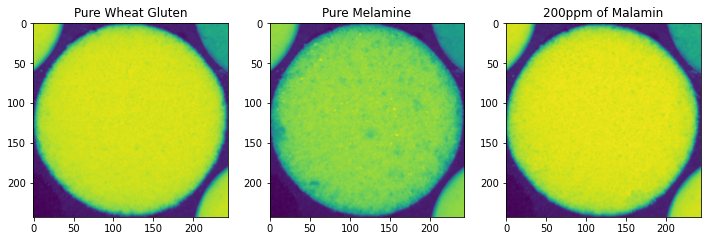

In [11]:
z_slice = 0 #@param {type: "slider", min: 0, max: 228}
fig, ax = plt.subplots(1,3, figsize=(10, 10));
plt.tight_layout();
ax[0].imshow(wheat_gluten_pure_data_mat[:, :, z_slice]);
ax[0].set_title('Pure Wheat Gluten');
ax[1].imshow(melamine_pure_data_mat[:, :, z_slice]);
ax[1].set_title('Pure Melamine');
ax[2].imshow(m_200ppm_data_mat[:, :, z_slice]);
ax[2].set_title('200ppm of Malamin');

No we can slice along one of the image axis (either x or y) to check out the spectral data. Here I am slicing along the x axis. 

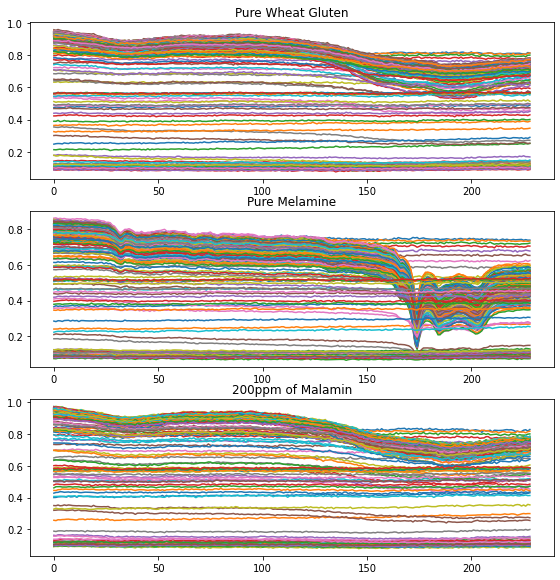

In [12]:
x_slice = 50 #@param {type: "slider", min: 0, max: 242}
fig, ax = plt.subplots(3,1, figsize=(8,8));
plt.tight_layout()
ax[0].plot(wheat_gluten_pure_data_mat[x_slice, :, :].T)
ax[0].set_title('Pure Wheat Gluten');
ax[1].plot(melamine_pure_data_mat[x_slice, :, :].T)
ax[1].set_title('Pure Melamine');
ax[2].plot(m_200ppm_data_mat[x_slice, :, :].T)
ax[2].set_title('200ppm of Malamin');
plt.show()

Now we can pull the center(ish) pixel from each of the three training HSIs (Hyper Spectral Images) just to take a look at them. The pure melamine spectrum is pretty prenounced, however the low concentration melamine sample clearly has the backgroup spectrim of thw wheat gluten dominating. This is typical for in "target detection", but makes for a challenging problem. 

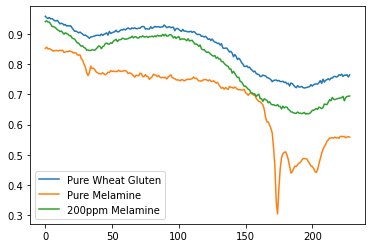

In [13]:
fig, ax = plt.subplots()
ax.plot(wheat_gluten_pure_data_mat[122, 122, :].T, label = 'Pure Wheat Gluten')
ax.plot(melamine_pure_data_mat[122, 122, :].T, label = 'Pure Melamine')
ax.plot(m_200ppm_data_mat[122, 122, :].T, label = '200ppm Melamine')
ax.legend()
plt.show()

Right now I am just cutting a 100x100 square out of each image. This really should be optimized for the full shape, but this is quick.

We can then view it by again slicing along the spectral axis. 

In [14]:
crop_size = 100
left = int(np.floor((x_size - crop_size)/2))
top = int(np.floor((y_size - crop_size)/2))
right = int(np.floor((x_size + crop_size)/2))
bottom = int(np.floor((y_size + crop_size)/2))

wheat_cropped = wheat_gluten_pure_data_mat[left:right, top:bottom, :]
melamine_cropped = melamine_pure_data_mat[left:right, top:bottom, :]
m_200ppm_cropped = m_200ppm_data_mat[left:right, top:bottom, :]

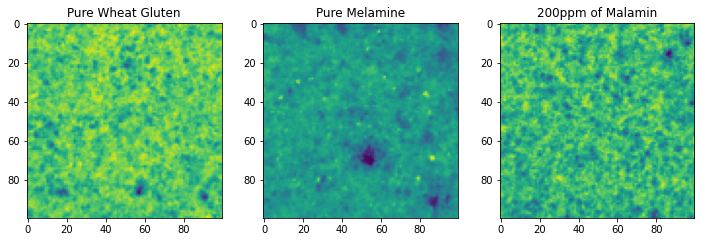

In [15]:
z_slice = 34 #@param {type: "slider", min: 0, max: 242}
fig, ax = plt.subplots(1,3, figsize=(10, 10));
plt.tight_layout();
ax[0].imshow(wheat_cropped[:, :, z_slice]);
ax[0].set_title('Pure Wheat Gluten');
ax[1].imshow(melamine_cropped[:, :, z_slice]);
ax[1].set_title('Pure Melamine');
ax[2].imshow(m_200ppm_cropped[:, :, z_slice]);
ax[2].set_title('200ppm of Malamin');

# Preprocessing the Data

## Savitzky-Golay filter

In [27]:
def apply_sgfilter(matrix, window_length, polyorder, deriv):
  output = np.empty(np.shape(matrix))
  for i in range(np.shape(matrix)[0]):
    for j in range(np.shape(matrix)[1]):
      output[i][j] = savgol_filter(matrix[i, j, :], window_length, polyorder, deriv=deriv)
      #output[i][j] = np.gradient(sg_filter)
  return output

First, we are going to test a few smoothing parameters. We will be testing a few different window size/polynomial ratios. The NIRPyResearch articles below give a very good explination of this process, the code is mainly inspired by (or copied from) there.

In [28]:
# https://nirpyresearch.com/choosing-optimal-parameters-savitzky-golay-smoothing-filter/
# https://nirpyresearch.com/savitzky-golay-smoothing-method/
# Set some reasonable parameters to start with
w = 5
p = 2
# Calculate three different smoothed spectra
# first derivative
melamine_sgfilter_1_d1 = apply_sgfilter(melamine_cropped, w, polyorder = p, deriv=1)
melamine_sgfilter_2_d1 = apply_sgfilter(melamine_cropped, 2*w+1, polyorder = p, deriv=1)
melamine_sgfilter_3_d1 = apply_sgfilter(melamine_cropped, 4*w+1, polyorder = 3*p, deriv=1)
# second derivative
melamine_sgfilter_1_d2 = apply_sgfilter(melamine_cropped, w, polyorder = p, deriv=2)
melamine_sgfilter_2_d2 = apply_sgfilter(melamine_cropped, 2*w+1, polyorder = p, deriv=2)
melamine_sgfilter_3_d3 = apply_sgfilter(melamine_cropped, 4*w+1, polyorder = 3*p, deriv=2)

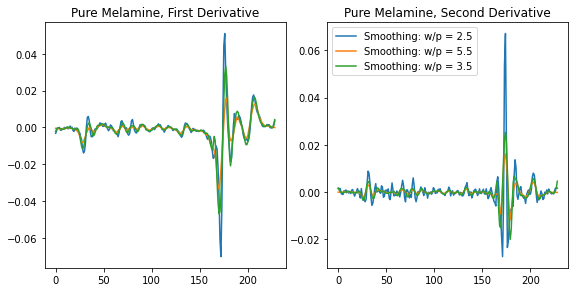

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.tight_layout()
axs[0].plot(melamine_sgfilter_1_d1[50, :, :][0], label = 'Smoothing: w/p = 2.5')
axs[0].plot(melamine_sgfilter_2_d1[50, :, :][0], label = 'Smoothing: w/p = 5.5')
axs[0].plot(melamine_sgfilter_3_d1[50, :, :][0], label = 'Smoothing: w/p = 3.5')
axs[0].set_title('Pure Melamine, First Derivative');
axs[1].plot(melamine_sgfilter_1_d2[50, :, :][0], label = 'Smoothing: w/p = 2.5')
axs[1].plot(melamine_sgfilter_2_d2[50, :, :][0], label = 'Smoothing: w/p = 5.5')
axs[1].plot(melamine_sgfilter_3_d3[50, :, :][0], label = 'Smoothing: w/p = 3.5')
axs[1].set_title('Pure Melamine, Second Derivative');
plt.legend()
plt.show()

In [30]:
wheat_preprocessed = apply_sgfilter(wheat_cropped, window_length = w, polyorder = p, deriv=2)
meamine_preprocessed = apply_sgfilter(melamine_cropped, window_length = w, polyorder = p, deriv=2)
m_200ppm_preprocessed = apply_sgfilter(m_200ppm_cropped, window_length = w, polyorder = p, deriv=2)
dataset_preprocessing = np.concatenate((wheat_preprocessed, meamine_preprocessed, m_200ppm_preprocessed))

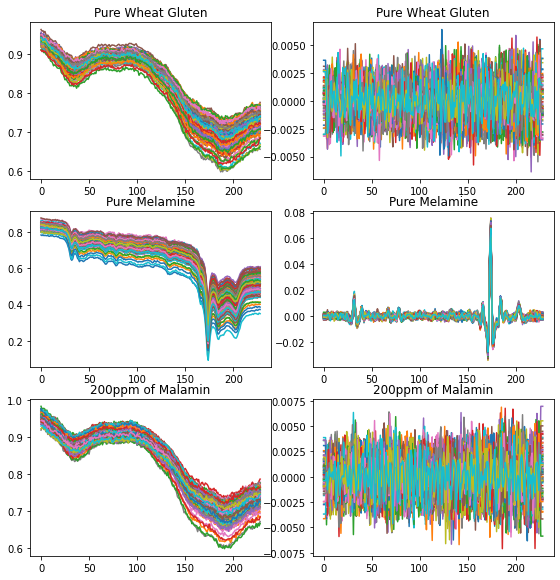

In [31]:
x_slice = 49 #@param {type: "slider", min: 0, max: 99}
fig, axs = plt.subplots(3, 2, figsize=(8,8))
plt.tight_layout()
axs[0, 0].plot(wheat_cropped[x_slice, :, :].T)
axs[0, 0].set_title('Pure Wheat Gluten');
axs[1, 0].plot(melamine_cropped[x_slice, :, :].T)
axs[1, 0].set_title('Pure Melamine');
axs[2, 0].plot(m_200ppm_cropped[x_slice, :, :].T)
axs[2, 0].set_title('200ppm of Malamin');
axs[0, 1].plot(wheat_preprocessed[x_slice, :, :].T)
axs[0, 1].set_title('Pure Wheat Gluten');
axs[1, 1].plot(meamine_preprocessed[x_slice, :, :].T)
axs[1, 1].set_title('Pure Melamine');
axs[2, 1].plot(m_200ppm_preprocessed[x_slice, :, :].T)
axs[2, 1].set_title('200ppm of Malamin');
plt.show()

Here I am going to great a few labels for a supervised learning algorthem. 

In [45]:
def create_label(matrix, label):
  output = np.empty(np.shape(matrix[:,:,-1]))
  for i in range(np.shape(matrix)[0]):
    for j in range(np.shape(matrix)[1]):
      output[i][j] = label
  return output

In [46]:
wheat_labels = create_label(wheat_cropped, 0)
melamine_labels = create_label(melamine_cropped, 1)
#m_200ppm_labels = create_label(m_200ppm_preprocessed, 200/1000000)
m_200ppm_labels = create_label(m_200ppm_cropped, 1)
wheat_labels_flat = np.reshape(wheat_labels, (crop_size * crop_size), order = 'F')
melamine_labels_flat = np.reshape(melamine_labels, (crop_size * crop_size), order = 'F')
m_200ppm_labels_flat = np.reshape(m_200ppm_labels, (crop_size * crop_size), order = 'F')

In [47]:
wheat_flat = np.reshape(wheat_cropped, (crop_size * crop_size, z_size), order = 'F')
melamine_flat = np.reshape(melamine_cropped, (crop_size * crop_size, z_size), order = 'F')
m_200ppm_flat = np.reshape(m_200ppm_cropped, (crop_size * crop_size, z_size), order = 'F')

In [48]:
dataset = np.concatenate((wheat_flat, melamine_flat, m_200ppm_flat))
labels = np.concatenate((wheat_labels_flat, melamine_labels_flat, m_200ppm_labels_flat))

In [49]:
wheat_preprocessed_labels = create_label(wheat_preprocessed, 0)
melamine_preprocessed_labels = create_label(meamine_preprocessed, 1)
#m_200ppm_labels = create_label(m_200ppm_preprocessed, 200/1000000)
m_200ppm_preprocessed_labels = create_label(m_200ppm_preprocessed, 1)
wheat_preprocessed_labels_flat = np.reshape(wheat_preprocessed_labels, (crop_size * crop_size), order = 'F')
melamine_preprocessed_labels_flat = np.reshape(melamine_preprocessed_labels, (crop_size * crop_size), order = 'F')
m_200ppm_preprocessed_labels_flat = np.reshape(m_200ppm_preprocessed_labels, (crop_size * crop_size), order = 'F')

In [50]:
wheat_preprocessed_flat = np.reshape(wheat_preprocessed, (crop_size * crop_size, z_size), order = 'F')
meamine_preprocessed_flat = np.reshape(meamine_preprocessed, (crop_size * crop_size, z_size), order = 'F')
m_200ppm_preprocessed_flat = np.reshape(m_200ppm_preprocessed, (crop_size * crop_size, z_size), order = 'F')

In [51]:
dataset_preprocessed = np.concatenate((wheat_preprocessed_flat, meamine_preprocessed_flat, m_200ppm_preprocessed_flat))
labels_preprocessed = np.concatenate((wheat_preprocessed_labels_flat, melamine_preprocessed_labels_flat, m_200ppm_preprocessed_labels_flat))

In [52]:
print(np.shape(dataset))
print(np.shape(labels))

(30000, 229)
(30000,)


In [53]:
print(np.shape( ))
print(np.shape(labels_preprocessed))

(30000, 229)
(30000,)


## PCA Decomposition


Here I am letting the PCA algorthem decompose the spectrum in some number of principle components based on some describable variance criteria. That is to say, n compoenents will be solved until some percetage of variance is explained by the PCA decompisition.  

In [61]:
pca = PCA(n_components=0.98, svd_solver = 'full')
pca.fit(dataset)
print(pca)
print('The number of components is: ' + str(len(pca.explained_variance_ratio_)))

PCA(n_components=0.98, svd_solver='full')
The number of components is: 1


In [62]:
pca_preprocessed = PCA(n_components=0.98, svd_solver = 'full')
pca_preprocessed.fit(dataset_preprocessed)
print(pca_preprocessed)
print('The number of components is: ' + str(len(pca_preprocessed.explained_variance_ratio_)))

PCA(n_components=0.98, svd_solver='full')
The number of components is: 113


We can graph the variance explained by each additional PC. for this problem a large amount if variance can be explained by a single PC. This is typical for spectral data since it is highly correlated. 

This is handy since now we have a means to transform our large number of corrilated spectral points into a number of uncorrilated features (in the form of orthogonal PCs). 

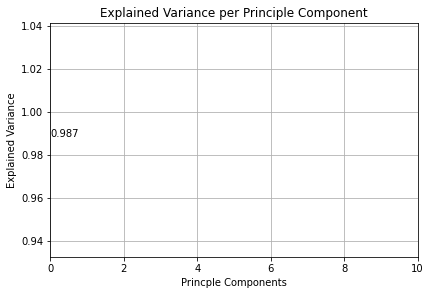

In [63]:
PCs_to_view = 10
fig, ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_)
ax.set(xlabel='Princple Components', ylabel='Explained Variance',)
plt.tight_layout();
ax.grid()
ax.xaxis
for x,y in zip(range(PCs_to_view),pca.explained_variance_ratio_):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,3), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center
plt.xlim(0,PCs_to_view)
plt.title('Explained Variance per Principle Component')
plt.show()

# Data Pipeline and ML Model

I am going to give a SVM a shot at labeling outliers. The idea is that the spectral preprocessing and decompisiton give the SVM the oppertunity to be able to descriminate the low concetration melamine spectra from background wheat gluten. 

We can tune the C parameter with a hyperparameter tuner, we well as play with other options like the kernal type. At this point it is worth pointing out we have other parameters to consider as well (for example the SG Filters parameters). We will start with the model parameters to keep things simple. 

In [31]:
val_split = 0.3
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=val_split, random_state=0)

In [32]:
model = svm.SVC()
#model.fit(dataset_transformed, labels)

I want to try to see how the stock sklearn SVM does on both the preprocessed data  as well as the unprocessed data.

In [33]:
#%%timeit
# the timeit reports a value of ~5 min 20 sec. for the unpreprocessed data
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(model, dataset, labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.902 (0.002)


In [ ]:
#%%timeit
# the timeit reports a value of ~5 min 20 sec. for the unpreprocessed data
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(model, dataset_preprocessed, labels_preprocessed, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [35]:
model.fit(X_train, y_train)

SVC()

In [36]:
test = 0
print(y_test[test])
print(model.predict(X_test[test].reshape(1, -1)))

0.0
[0.]


In [41]:
def predict(matrix, model):
  output = np.empty(np.shape(matrix[:,:,-1]))
  print(np.shape(matrix))  
  print(np.shape(matrix))
  for i in range(np.shape(matrix)[0]):
    for j in range(np.shape(matrix)[1]):
      preprocessed = apply_sgfilter(matrix[i, j], w, p, 1)
      pca_transform = pca.transform(preprocessed)
      output[i][j] = model.predict(pca_transform.reshape(1, -1))
  return output

In [42]:
test_1 = loadmat('/content/data_files/Test_1.mat')
test_1_mat = np.reshape(test_1['z']['data'], (x_size, y_size, z_size), order = 'F')
test_1_predict = predict(test_1_mat, model)

(243, 244, 229)
(243, 244, 229)


IndexError: ignored

In [ ]:
plt.imshow(test_1_predict)